### Inicializaciones

In [87]:
#!pip install gym
#!pip install pygame

In [88]:
import gym
import numpy as np
import time

### Funciones auxiliares

In [89]:
def epsilon_greedy_policy(state, Q, epsilon=0.25):
    explore = np.random.binomial(1, epsilon)
    if explore:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state])
    return action

In [90]:
# Se busca aprender rápidamente al principio, y después ir aprendiendo más lento en busca de mejores resultados
def get_learning_rate(t, min_rate=0.001):
    alpha_decay_steps = 25
    return max(min_rate, min(1.0, 1.0 - np.log10((t+1)/alpha_decay_steps)))

In [91]:
#Se busca que epsilon disminuya con el tiempo, queremos evitar el uso de mínimos subóptimos al comienzo del entrenamiento,
# para esto hacemos que explore la mayor parte del tiempo al comienzo y luego vaya disminuyendo
def get_epsilon(t, min_epsilon=0.05):
    epsilon_decay_step = 10
    return max(min_epsilon, min(1, 1.0 - np.log10((t+1)/epsilon_decay_step)))

In [92]:
def q_learning(state, Q, episode):   
    done = False
    gamma = 0.999
    while not done:
        alpha = get_learning_rate(episode)
        epsilon = get_epsilon(episode)
        action = epsilon_greedy_policy(state, Q, epsilon)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        current_Q_value = Q[state][action]
        discrete_obs = get_state(obs)
        Q[state][action] = current_Q_value + alpha*(reward + gamma*np.max(Q[discrete_obs][:]) - current_Q_value)
        state = discrete_obs

In [93]:
def optimal_policy(state, Q):
    action = np.argmax(Q[state])
    return action

### Discretización de variables de la observación

Como la posición del carrito y su aceleración no son tan relevantes como la posición del palito y su velocidad, se discretiza utilizando una menor cantidad de contenedores de mayor tamaño. Por otro lado, tanto la aceleración angular como el ángulo del palito son las variables de mayor importancia, son las que van a variar con una mayor velocidad. Por lo tanto, se discretizan con una mayor cantidad de contenedores de menor tamaño.

In [94]:
cart_position_bins, cart_pos_step = np.linspace(-2.4, 2.4, 4, retstep=True)
cart_acc_bins, cart_acc_step = np.linspace(-100, 100, 3, retstep=True)
pole_angle_bins, pole_angle_step = np.linspace(-.2,.2, 8, retstep=True)
angular_acc_bins, angular_acc_step = np.linspace(-5000, 5000, 5, retstep=True)
print("cart_pos_step: ", cart_pos_step)
print("cart_acc_step: ", cart_acc_step)
print("pole_angle_step: ", pole_angle_step)
print("angular_acc_step: ", angular_acc_step)

cart_pos_step:  1.5999999999999999
cart_acc_step:  100.0
pole_angle_step:  0.05714285714285715
angular_acc_step:  2500.0


In [95]:
def get_state(obs):
    cart_pos = np.digitize(obs[0], cart_position_bins)
    cart_acc = np.digitize(obs[1], cart_acc_bins)
    pole_ang = np.digitize(obs[2], pole_angle_bins)
    ang_acc = np.digitize(obs[3], angular_acc_bins)
    state = tuple([cart_pos, cart_acc, pole_ang, ang_acc])
    return state

### Inicialización de Q

In [97]:
position_bins_count = cart_position_bins.size + 1
acc_bins_count = cart_acc_bins.size + 1
angle_bins_count = pole_angle_bins.size + 1
angular_acc_bins_count = angular_acc_bins.size + 1
print("Valid cart position bins: 0 - ", position_bins_count - 1)
print("Valid cart acceleration bins: 0 - ", acc_bins_count - 1)
print("Valid pole angle bins: 0 - ", angle_bins_count - 1)
print("Valid pole acceleration bins: 0 - ", angular_acc_bins_count - 1)
Q = np.random.random((position_bins_count,acc_bins_count,angle_bins_count,angular_acc_bins_count,2))
Q.shape

Valid cart position bins: 0 -  4
Valid cart acceleration bins: 0 -  3
Valid pole angle bins: 0 -  8
Valid pole acceleration bins: 0 -  5


(5, 4, 9, 6, 2)

### Entrenamiento

In [98]:
env = gym.make('CartPole-v1', new_step_api=True)
done = False
max_episodes = 1500
trainedQ = Q.copy()
for i in range(max_episodes):
    obs = env.reset()
    if i % 100 == 0 or i == max_episodes - 1:
        print('Episode: ', i)
    q_learning(get_state(obs), trainedQ, i)
env.close()

Episode:  0
Episode:  100
Episode:  200
Episode:  300
Episode:  400
Episode:  500
Episode:  600
Episode:  700
Episode:  800
Episode:  900
Episode:  1000
Episode:  1100
Episode:  1200
Episode:  1300
Episode:  1400
Episode:  1499


### Ejecución con la policy óptima

El mejor resultado esperado de ejecutar la policy óptima obtenida es 500 en promedio en 100 corridas continuas, ya que es el máximo de pasos que se puede dar en el entorno, este final se marca en la variable truncation.

In [107]:
time.sleep(1)
env = gym.make('CartPole-v1', new_step_api=True)
tries = 100
rewards = np.zeros(tries)
print("Playing optimal policy")
for i in range(tries):
    episode_reward= 0
    obs = env.reset(seed = i)
    done = False
    while not done:
        state = get_state(obs)
        action = optimal_policy(state, trainedQ)
        obs, reward, termination, truncation, info = env.step(action)
        done = termination or truncation
        episode_reward += reward
    rewards[i] = episode_reward
env.close()
print("Average reward: ", np.mean(rewards))

Playing optimal policy
Average reward:  498.92


In [102]:
#Guardar el resutlado de Q en un archivo .npy
if np.mean(rewards) > 450:
    np.save('TrainedQ.npy', trainedQ)
    trainedQ.shape

(5, 4, 9, 6, 2)

In [100]:
def plot(x,y, x_text, y_text, title):
    import matplotlib.pyplot as plt
    scatter = plt.scatter(x, y, color ="green", s = 10)
    plt.title(title)
    plt.xlabel(x_text)
    plt.ylabel(y_text)
    plt.scatter(x, y, color ="green", s = 10)
    plt.show()

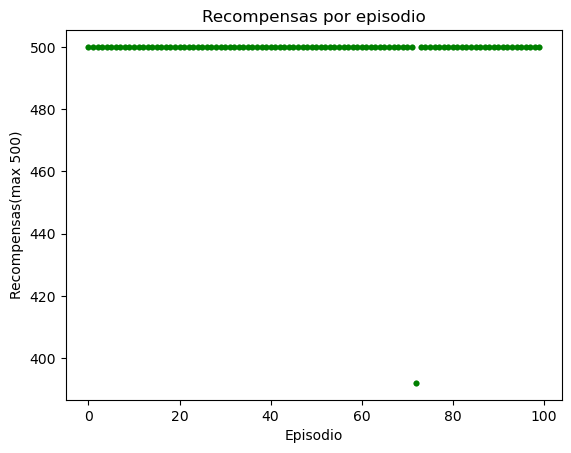

In [101]:

plot(range(tries), rewards, "Episodio", "Recompensas(max 500)", "Recompensas por episodio")